In [8]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
pip install openpyxl


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Preprocessing

In [2]:
import pandas as pd

# Load the dataset from the uploaded file
file_path = 'dataset.xlsx'
data = pd.read_excel(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()


,"Min,Max,Modal PriceLasalgaon from 05-Mar-2005To05-Oct-2024 (Total-4959) (Total-4959)",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,Sl no.,District Name,Market Name,Commodity,Variety,Grade,Min Price (Rs./Quintal),Max Price (Rs./Quintal),Modal Price (Rs./Quintal),Price Date
1,1,Nashik,Lasalgaon,Onion,Other,FAQ,51,752,300,2018-11-23 00:00:00
2,2,Nashik,Lasalgaon,Onion,Other,FAQ,61,1931,1651,2021-08-03 00:00:00
3,3,Nashik,Lasalgaon,Onion,Other,FAQ,70,288,130,2018-12-29 00:00:00
4,4,Nashik,Lasalgaon,Onion,Other,FAQ,70,320,165,2018-12-28 00:00:00


XG Boost Model

In [3]:
# Renaming the columns for easier access
data.columns = ['Index', 'District', 'Market', 'Commodity', 'Variety', 'Grade', 'Min_Price', 'Max_Price', 'Modal_Price', 'Price_Date']

# Dropping the first row and resetting the index
data = data.drop([0]).reset_index(drop=True)

# Converting "Price_Date" to datetime and "Modal_Price" to numeric
data['Price_Date'] = pd.to_datetime(data['Price_Date'], errors='coerce')
data['Modal_Price'] = pd.to_numeric(data['Modal_Price'], errors='coerce')

# Sorting the data by date
data = data.sort_values(by='Price_Date')

# Creating a target variable that represents if the price increased or decreased
data['Price_Change'] = data['Modal_Price'].diff().shift(-1)
data['Price_Change_Label'] = (data['Price_Change'] > 0).astype(int)  # 1 for increase, 0 for decrease

# Drop rows with missing values
data = data.dropna(subset=['Modal_Price', 'Price_Change'])

# Keep only the relevant columns
processed_data = data[['Price_Date', 'Modal_Price', 'Price_Change_Label']]

# Display the processed data
processed_data.head()


,Price_Date,Modal_Price,Price_Change_Label
96,2005-03-07,251,0
3212,2005-03-09,165,1
186,2005-03-09,180,1
102,2005-03-11,275,0
185,2005-03-14,241,1


In [4]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Splitting the data into features and target variable
X = processed_data[['Modal_Price']]
y = processed_data['Price_Change_Label']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initializing the XGBoost classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Training the model
xgb_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = xgb_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

accuracy, report


(0.5584677419354839,
 '              precision    recall  f1-score   support\n\n           0       0.58      0.61      0.60       526\n           1       0.53      0.50      0.51       466\n\n    accuracy                           0.56       992\n   macro avg       0.56      0.56      0.55       992\nweighted avg       0.56      0.56      0.56       992\n')

In [5]:
# Optimizing the XGBoost model with reduced boosting rounds and faster configuration
xgb_model_optimized = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, max_depth=3)

# Training the optimized model
xgb_model_optimized.fit(X_train, y_train)

# Predicting on the test set
y_pred_optimized = xgb_model_optimized.predict(X_test)

# Evaluating the optimized model
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
report_optimized = classification_report(y_test, y_pred_optimized)

accuracy_optimized, report_optimized


(0.5473790322580645,
 '              precision    recall  f1-score   support\n\n           0       0.56      0.71      0.62       526\n           1       0.53      0.37      0.43       466\n\n    accuracy                           0.55       992\n   macro avg       0.54      0.54      0.53       992\nweighted avg       0.54      0.55      0.53       992\n')

HMM with XGBoost

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from hmmlearn import hmm
from xgboost import XGBClassifier

# Step 1: Load and Preprocess Data
file_path = 'dataset.xlsx'
data = pd.read_excel(file_path)

# Rename columns and preprocess
data.columns = ['Index', 'District', 'Market', 'Commodity', 'Variety', 'Grade', 'Min_Price', 'Max_Price', 'Modal_Price', 'Price_Date']
data = data.drop([0]).reset_index(drop=True)
data['Price_Date'] = pd.to_datetime(data['Price_Date'], errors='coerce')
data['Modal_Price'] = pd.to_numeric(data['Modal_Price'], errors='coerce')

# Sort by date and drop missing values
data = data.sort_values(by='Price_Date').dropna(subset=['Modal_Price'])

# Creating a target variable (1 = price increase, 0 = price decrease)
data['Price_Change'] = data['Modal_Price'].diff().shift(-1)
data['Price_Change_Label'] = (data['Price_Change'] > 0).astype(int)
data = data.dropna(subset=['Price_Change'])

# Step 2: Train Hidden Markov Model (HMM)
# Prepare the sequence data for HMM
modal_prices = data['Modal_Price'].values.reshape(-1, 1)  # HMM needs 2D input

# Define and fit an HMM
model_hmm = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=100)
model_hmm.fit(modal_prices)

# Predict the hidden states (0 or 1) representing price decrease/increase
hidden_states = model_hmm.predict(modal_prices)

# Step 3: Add HMM Probabilities as Features
# Compute the probabilities of the hidden states
state_probs = model_hmm.predict_proba(modal_prices)

# Add the HMM probabilities to the original dataframe
data['HMM_Prob_Increase'] = state_probs[:, 1]  # Probability of price increase
data['HMM_Prob_Decrease'] = state_probs[:, 0]  # Probability of price decrease

# Step 4: Train XGBoost Model with HMM features
# Prepare features and labels
X = data[['Modal_Price', 'HMM_Prob_Increase', 'HMM_Prob_Decrease']]
y = data['Price_Change_Label']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, max_depth=3)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)


Accuracy: 0.62
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.69      0.66       526
           1       0.61      0.55      0.58       466

    accuracy                           0.62       992
   macro avg       0.62      0.62      0.62       992
weighted avg       0.62      0.62      0.62       992



ARIMA

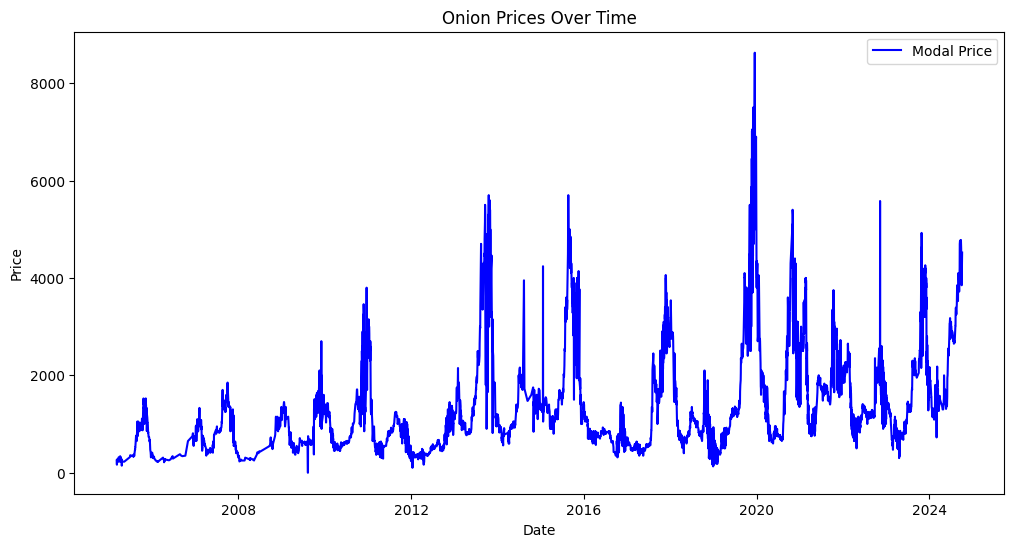

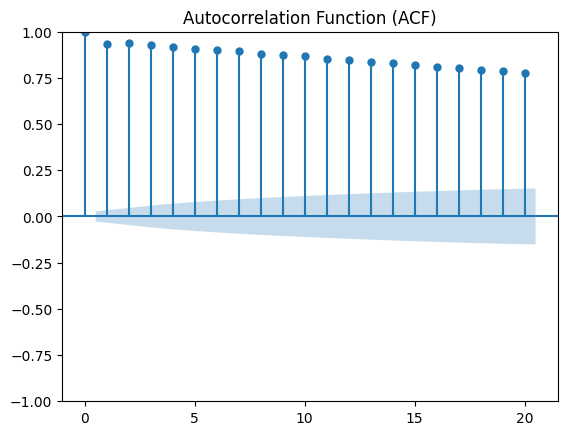

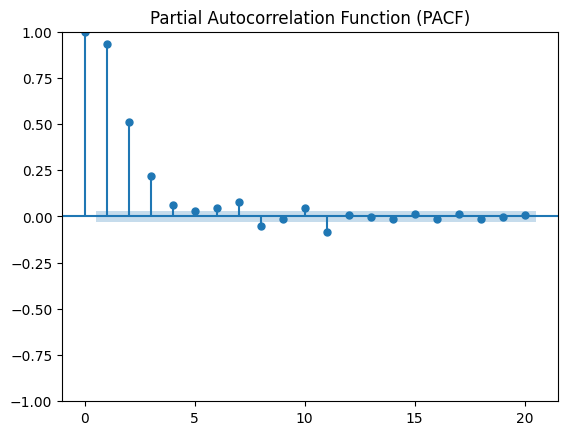

c:\Users\ajeev\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ajeev\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ajeev\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ajeev\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ajeev\AppData\Local

Last known price: 4520
First forecasted price: 4377.025753685394
Predicted price trend for the next 10 days: decrease
Forecasted Prices for the next 10 days:
  Price_Date  Predicted_Price
0 2024-10-05      4377.025754
1 2024-10-06      4420.813229
2 2024-10-07      4385.707819
3 2024-10-08      4384.168623
4 2024-10-09      4400.371359
5 2024-10-10      4398.419055
6 2024-10-11      4395.305618
7 2024-10-12      4398.166584
8 2024-10-13      4396.243699
9 2024-10-14      4396.314258


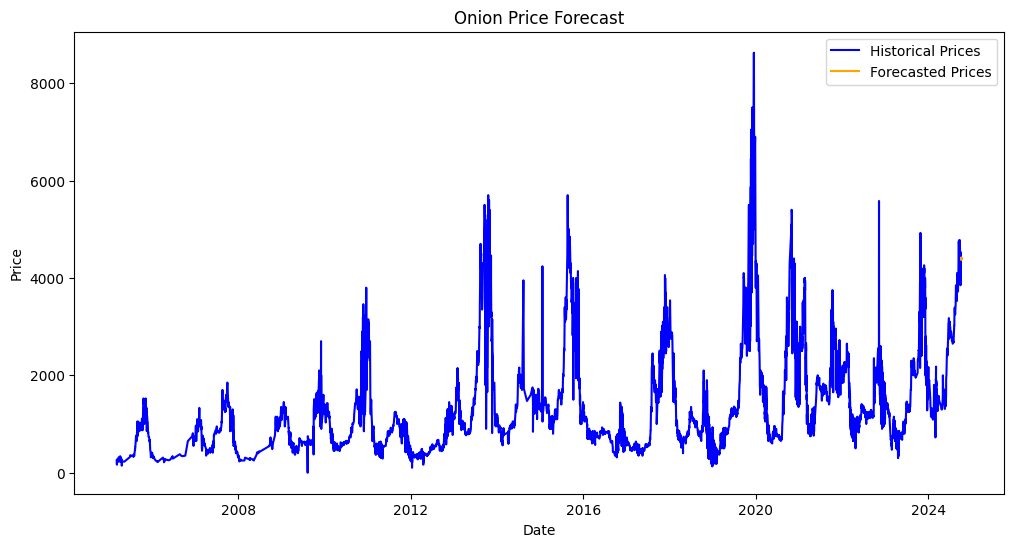

In [7]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Step 1: Load the dataset
file_path = 'dataset.xlsx'  # Replace with the path to your Excel file
data = pd.read_excel(file_path)

# Step 2: Preprocess the data
data.columns = ['Index', 'District', 'Market', 'Commodity', 'Variety', 'Grade', 'Min_Price', 'Max_Price', 'Modal_Price', 'Price_Date']
data = data.drop([0]).reset_index(drop=True)
data['Price_Date'] = pd.to_datetime(data['Price_Date'], errors='coerce')
data['Modal_Price'] = pd.to_numeric(data['Modal_Price'], errors='coerce')

# Drop missing values and sort by date
data = data.dropna(subset=['Modal_Price']).sort_values(by='Price_Date')

# Step 3: Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(data['Price_Date'], data['Modal_Price'], label='Modal Price', color='blue')
plt.title('Onion Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Step 4: ACF and PACF plots to determine p and q
plot_acf(data['Modal_Price'], lags=20)
plt.title('Autocorrelation Function (ACF)')
plt.show()

plot_pacf(data['Modal_Price'], lags=20)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

# Step 5: Train the ARIMA model
# We will use the Modal Price for the ARIMA model
# You can adjust the order based on ACF and PACF plots
p, d, q = 5, 1, 0  # Example values, adjust based on analysis
model_arima = ARIMA(data['Modal_Price'], order=(p, d, q))  # (p, d, q) parameters
model_arima_fit = model_arima.fit()

# Step 6: Model diagnostics
model_arima_fit.summary()  # Displays the summary of the fitted model

# Step 7: Forecasting future prices
# Predicting the next 10 days of prices
forecast = model_arima_fit.forecast(steps=10)
forecast_array = forecast.values if hasattr(forecast, 'values') else forecast  # Ensure it's a numpy array

future_dates = pd.date_range(start=data['Price_Date'].iloc[-1] + pd.Timedelta(days=1), periods=10)

# Step 8: Combine predictions with future dates
forecast_df = pd.DataFrame({'Price_Date': future_dates, 'Predicted_Price': forecast_array})

# Step 9: Determine whether the price will increase or decrease
# Compare last known price with the first forecasted price
last_known_price = data['Modal_Price'].iloc[-1]
first_forecasted_price = forecast_array[0]  # Accessing the first forecasted price

price_trend = "increase" if first_forecasted_price > last_known_price else "decrease"

# Step 10: Output results
print("Last known price:", last_known_price)
print("First forecasted price:", first_forecasted_price)
print("Predicted price trend for the next 10 days:", price_trend)
print("Forecasted Prices for the next 10 days:")
print(forecast_df)

# Optional: Plot the forecasted prices
plt.figure(figsize=(12, 6))
plt.plot(data['Price_Date'], data['Modal_Price'], label='Historical Prices', color='blue')
plt.plot(forecast_df['Price_Date'], forecast_df['Predicted_Price'], label='Forecasted Prices', color='orange')
plt.title('Onion Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
